#1 미션 개요

- LLM이 외부 문서의 정보를 참고하여 답변할 수 있도록 RAG를 구현해 보는 미션입
- LangChain을 이용해 RAG 시스템을 구현한 뒤, 사용된 문서와 관련된 질문을 하고 적절한 답변이 나오는지 확인

- 사용 데이터셋
  - 국세청에서 발간한 2024년 연말정산 신고 안내 문서를 활용
  - 연말정산 절차, 각종 공제 항목, 유의사항은 물론이고 2024년 기준으로 개정된 세법에 대한 정보도 있어서 RAG 시스템을 구현하고 검증하는 데 적합한 문서임

- 가이드라인
|구분|내용|
|-|-|
|문서 로드 및 청킹(Chunking)|- 먼저 사용할 문서를 불러오고, 검색 효율을 높이기 위해 문서를 적절한 길이로 나누는 청킹 작업을 수행<br>-다양한 청킹 옵션으로 실험을 반복하면서 최적의 옵션 탐색(필요한 경우 단순히 문자 수로 문서를 나누지 않고, 문서의 구조나 의미 고려 필요)|
|임베딩 생성 및 벡터 데이터베이스에 저장|-각 청크마다 임베딩을 생성하고, 이를 검색할 수 있도록 벡터 데이터베이스에 저장<br>-Hugging Face에서 어떤 모델을 사용하는지에 따라 검색 성능이 크게 달라질 수 있음<br>-특히 한국어 문서를 사용할 경우에는 모델 선정에 언어까지 고려해야 해요.벡터 데이터베이스의 종류도 다양<br>-구현의 편의성이나 검색 성능을 종합적으로 고려해 선택|
|언어 모델 및 토크나이저 설정|-Hugging Face에서 어떤 모델을 사용하면 좋을지 결정<br>-특히 한국어로 질문하고 응답받고 싶을 경우에는 언어도 고려하여 모델을 선정<br>-필요한 경우 양자화를 통해 메모리 부하를 줄이고 응답 속도 향상<br>-Temperature, penalty 등 텍스트 생성과 관련된 다양한 옵션을 적절한 값으로 설정|
|RAG 구현|-사용자의 질문이 들어왔을 때, 연관된 문서 청크를 찾아 맥락으로 활용해 답변을 생성하는 RAG 시스템을 구현|
|다양한 질문 입력 및 성능 평가|-RAG 시스템에 여러 질문을 던져 보면서 적절한 답변이 나오는지 평가<br>-질문은 문서 내용에 기반하여 답변의 정확성을 검증할 수 있는 질문이어야 좋음<br>-예를 들어 연말 정산 문서로 RAG 시스템을 구현했을 경우, 다음과 같은 질문을 해 볼 수 있음<br>&nbsp;&nbsp;&nbsp;&nbsp;-연말 정산 때 비거주자가 주의할 점을 알려 줘.<br>&nbsp;&nbsp;&nbsp;&nbsp;-2024년 개정 세법 중에 월세와 관련한 내용이 있을까?|

- (심화) 고급 RAG 기법 실험: 기본 RAG 구현을 완료했다면, 더 나아가 다양한 고급 기법들을 구현해 보고 성능이 나아지는지 확인
  - Hybrid searching, multi-query retrieval, contextual compression, reranking 등을 실험해 볼 수 있습니다.
(심화) Hugging Face 외의 LLM API 실험: 여유가 있다면, OpenAI API 등 Hugging Face가 아닌 LLM API를 사용해 RAG 시스템을 만들어 보고, 성능을 비교

#2 수행환경
- local에서 venv환경을 구성해서 수행
- https://github.com/mungmung1970/GenAI_RAG

##2.1 폴더 구조

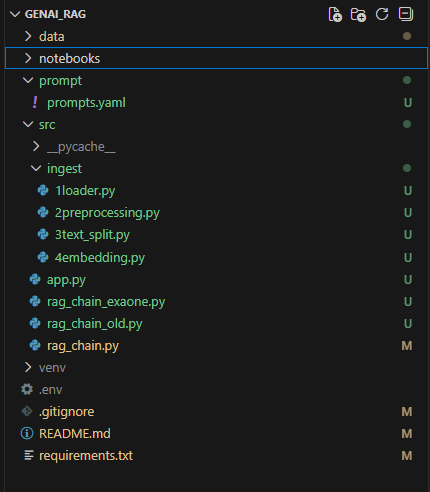    

##2.2 주요 설치 패키지: 상세설치 내역은 requirements.txt파일 참조
|Package|Version|
|-|-|
|langchain|0.3.12|
|langchain-community       |0.3.12 |
|langchain-core            |0.3.63|
|langchain-elasticsearch   |0.3.1|
|langchain-openai          |0.2.6|
|langchain-text-splitters  |0.3.3|
|langgraph-checkpoint      |3.0.1|
|langgraph-sdk             |0.2.12|
|langsmith                 |0.2.11|
|openai                    |1.109.1|
|pypdf                     |6.4.0|
|pypdfium2                 |5.1.0|


##2.3 벡터DB - Elastic Search/Kibana

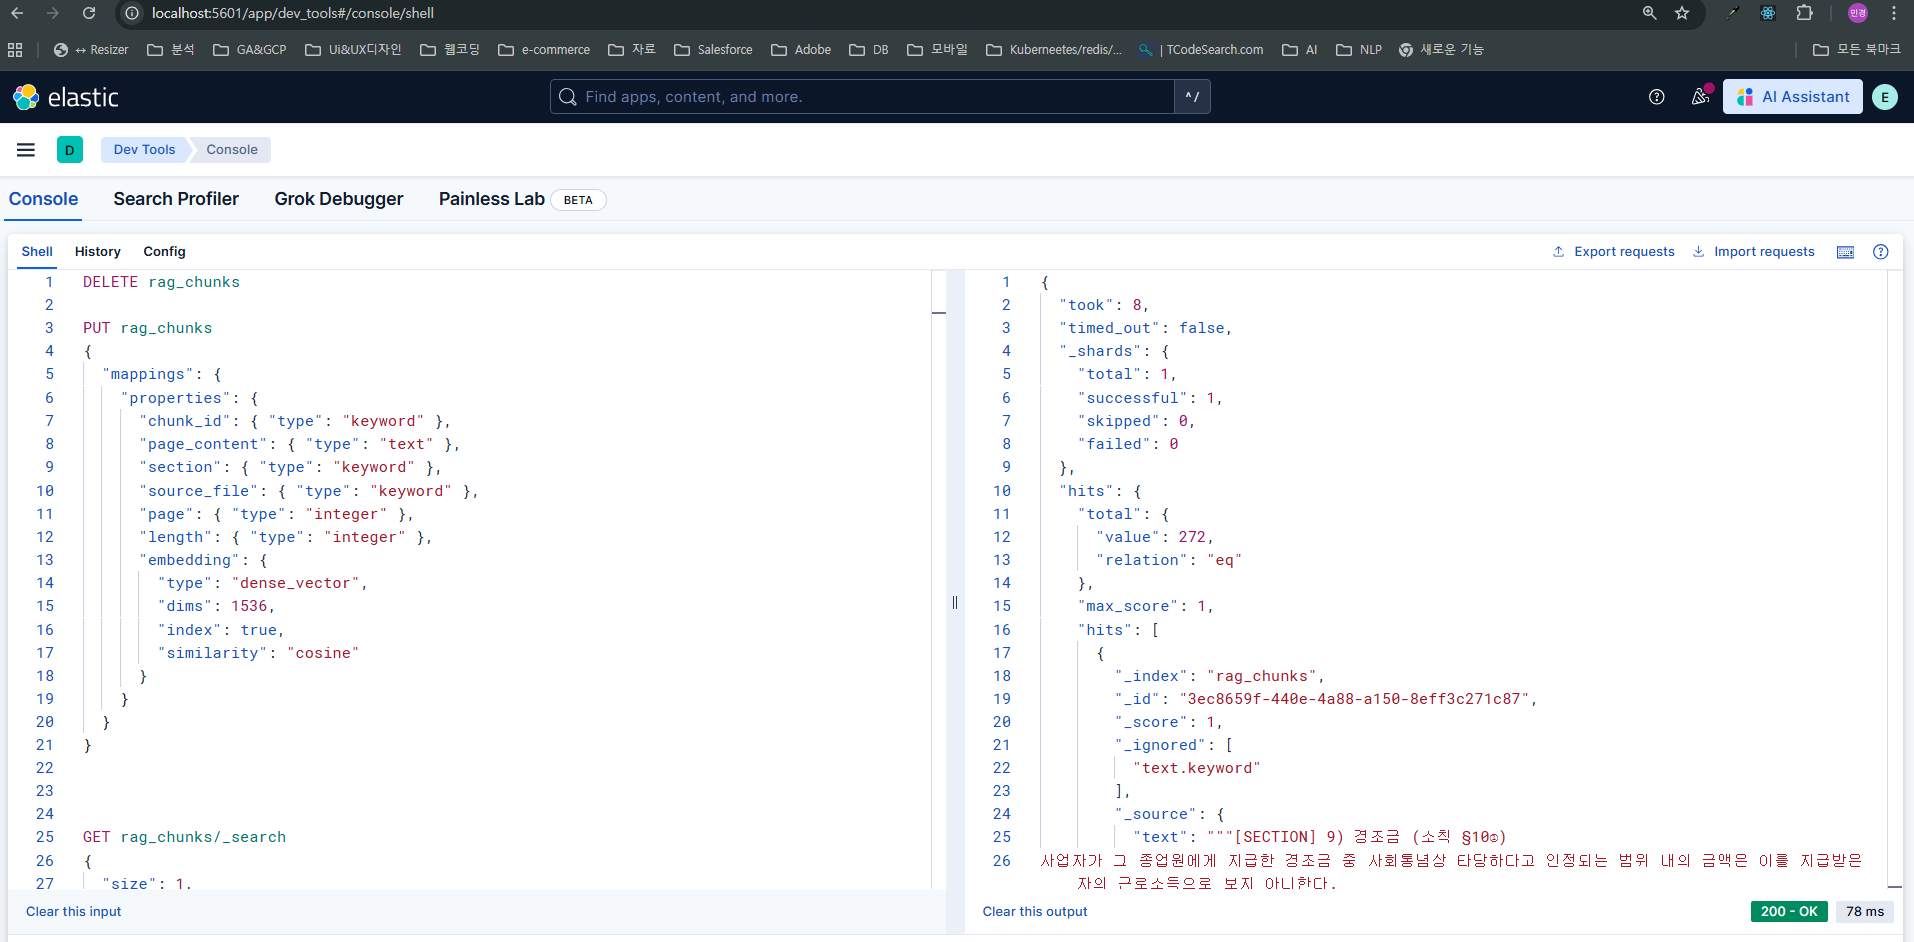

##2.4 실험모델
|구분|모델|비고|
|-|-|-|
|임베딩|text-embedding-3-small||
||bge-m3|다국어 처리가 우수하다고 하나 속도가 느림|
|Reranker|gpt-4o-mini||
|답변생성LLM|gpt-4o-mini|openAI API사용|
||deepseek-r1:1.5b|Local Ollama API사용(영어로 답변-속도 빠름, 한글 답변 실패)|
||mistral:7b|Local PC Ollama API사용(timeout - 시간 연장, MAX_CONTEXT_CHARS = 8000로제한-속도 매우 느림|
||llama3:8b-instruct-q4_0|Local  PC Ollama API사용-mistral과 동일 조건-속도 매우 느림, newline이 잘 되지 않아 잘못 이해할 소지가 있음|

##2.5 Local LLM모델

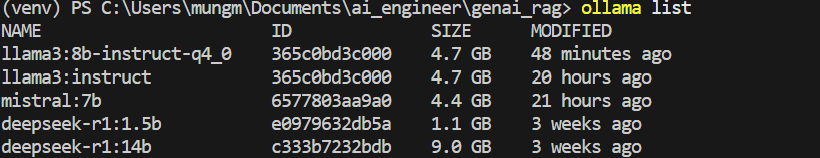

#3 수행내역 및 결과

##3.1 데이터 로드(1loader.py)

- PyPDFLoader, PDFPlumberLoader 두개 방식 비교
- txt, html, json파일로 저장
- PDFPlumberLoader의 경우 표도 같이 생성하는 방식으로 저장하였으나 대부분의 표가 인식되지 않았고, 표의 셀순서가 맞지 않게 텍스트도 저장됨
- 따라서 최종PyPDFLoader를 사용하여json파일로 저장
<br>**상용 솔루션 중에는 표인식 및 Markdown 또는 HTML로 저장, 그림인식 및 캡션 저장 등이 가능한 것이 있는 것으로 알고 있음**


###원본
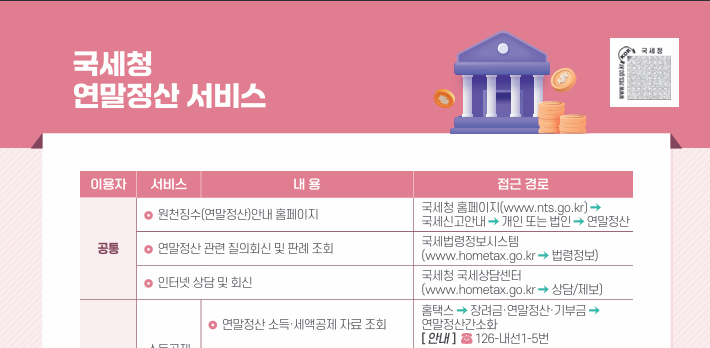

### pypdfloader.txt
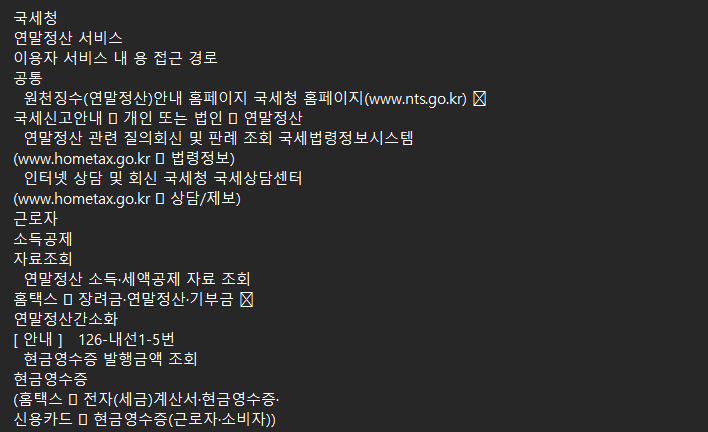

###pypdfloader.json
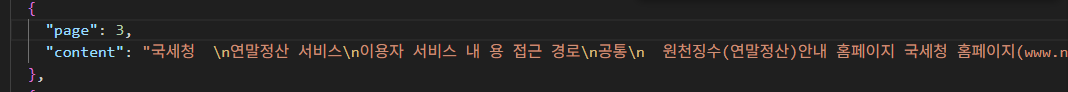

###pypdfloader.html
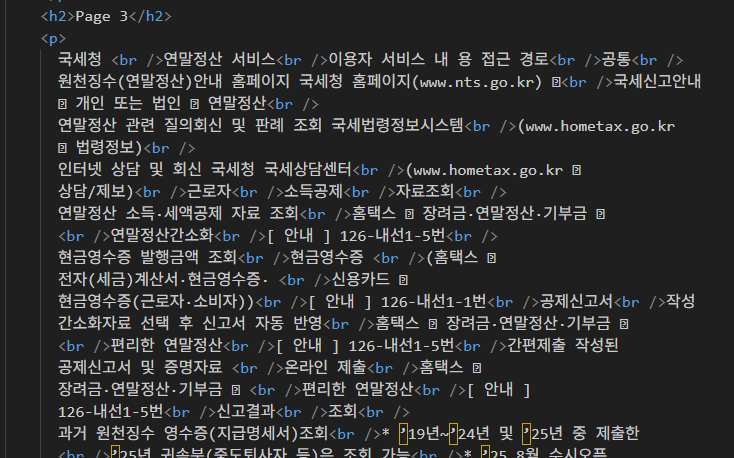

###pdfplumber.txt - 표 cell순서가 원본과 상이함
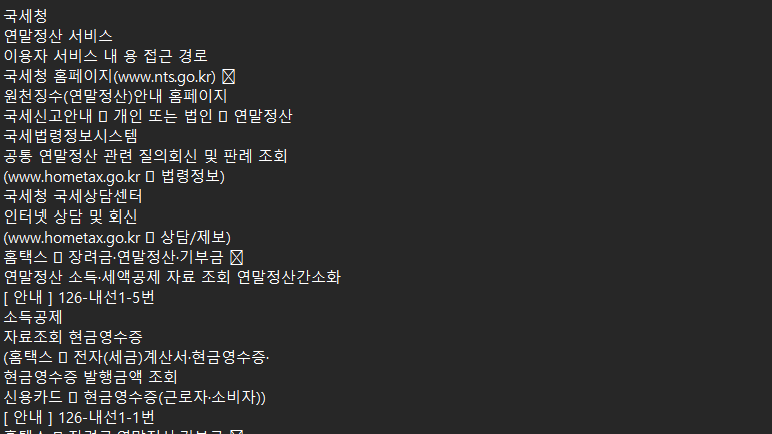

###content_with_tables.html - 표를 정확하게 인식하지 못함
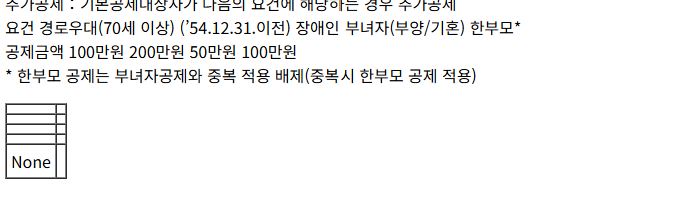

##3.2 데이터 전처리(2preprocessing.py)
- 불필요한 개행/공백 정리	✔
- 머리글/푸터 제거	✔
- 의미 있는 특수 기호 보존(O, ×, △)	✔
- 날짜 변환 (’25 → 2025)	✔
- 숫자 패턴 표준화(천단위 Comma제거 등)	✔
- 용어 표준화(동의어 매핑)	✔
- 문단 단위 재구성	✔
- 섹션/항목 “추정”	⚠ 가능하나 정확도 낮음

##3.3 Chunking
- MAX_CHARS = 2000
- MIN_CHARS = 600
- OVERLAP_CHARS = 250
- SECTION_BOOST = True  # [SECTION] 등장 시 chunk 경계 강화

###청킹결과
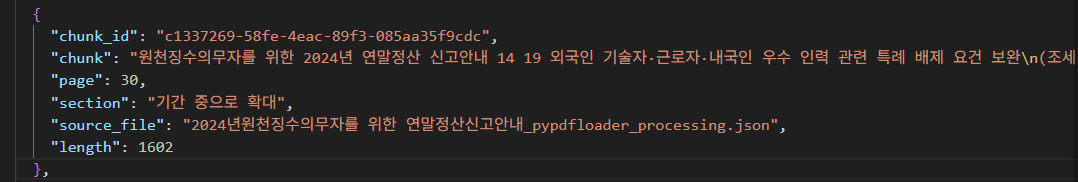

##3.4 Embedding

###(1) text-embedding-3-small(4embedding_openai.py)
####ES 저장 문서 구조
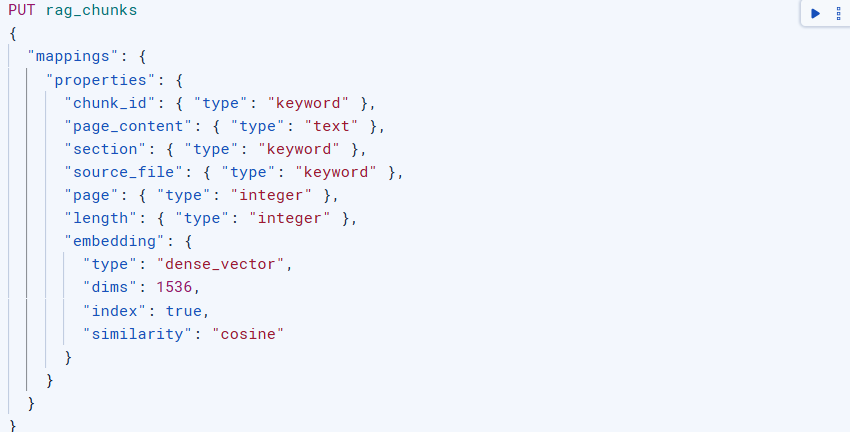

###(2) bge-m3(4embedding_bge.py)
####ES 저장 문서 구조
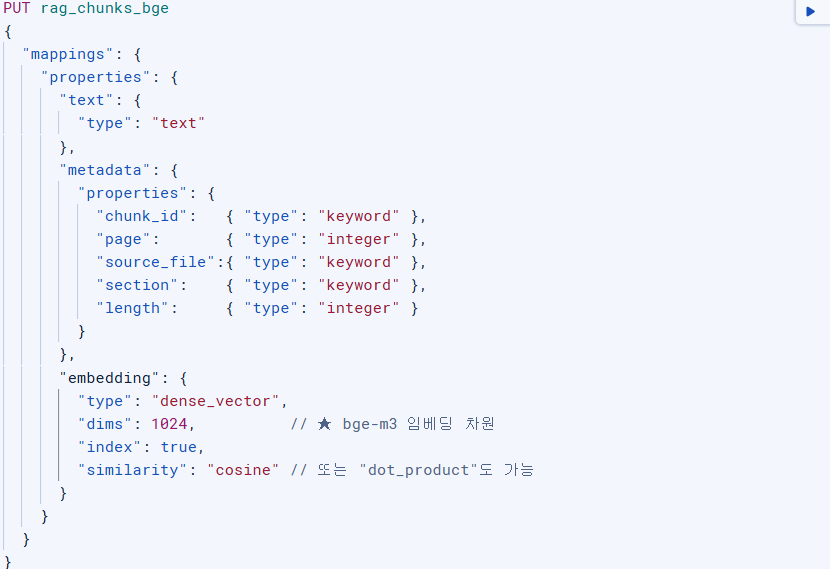

##3.5 Langchain_RAG(rag_chain.py)

###(1) gpt-4o-mini + text_embedding-3-small
- LangSmith + LCEL + Hybrid + Reranker
- 답변이 정확하게 잘됨(청킹결과 1번째 문서로 답변 생성)

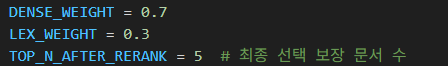

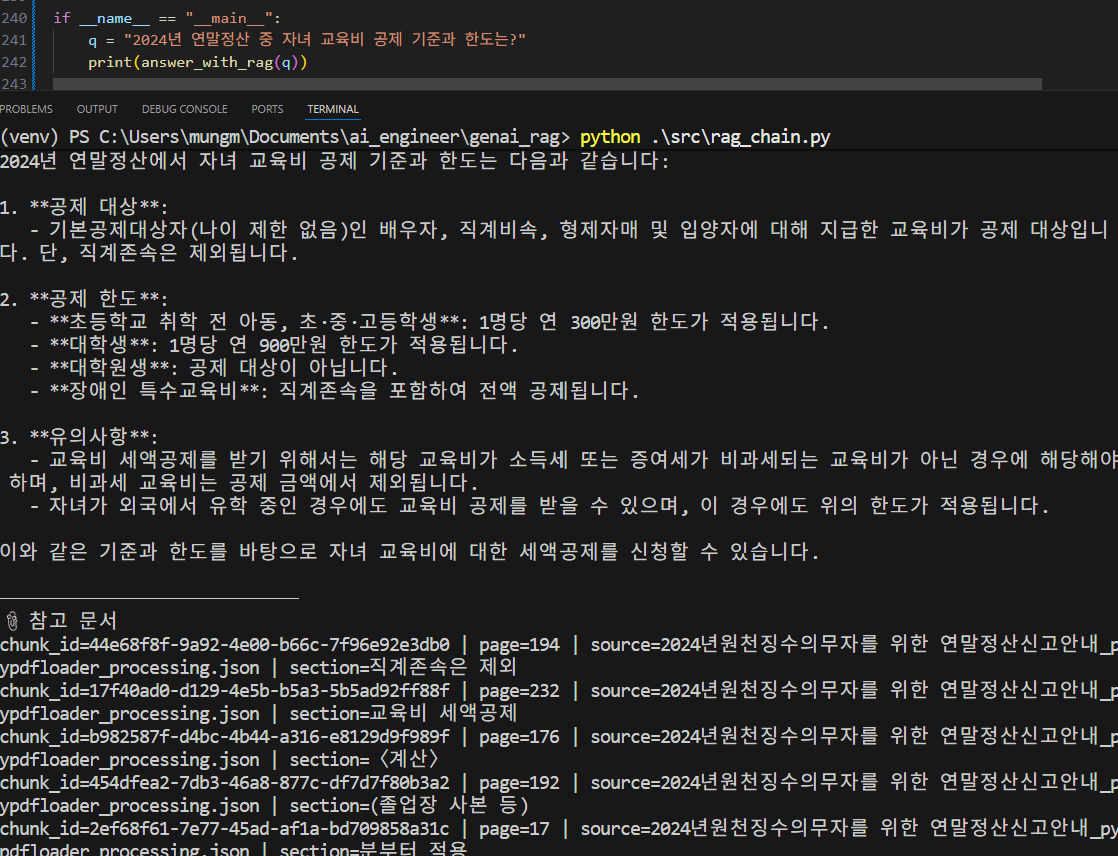

###(2) deepseek-r1:1.5b + text_embedding-3-small
- (1)과 동일한 promtp 템플릿 사용시 아래와 같이 LLM 답변이 영어로 생성됨


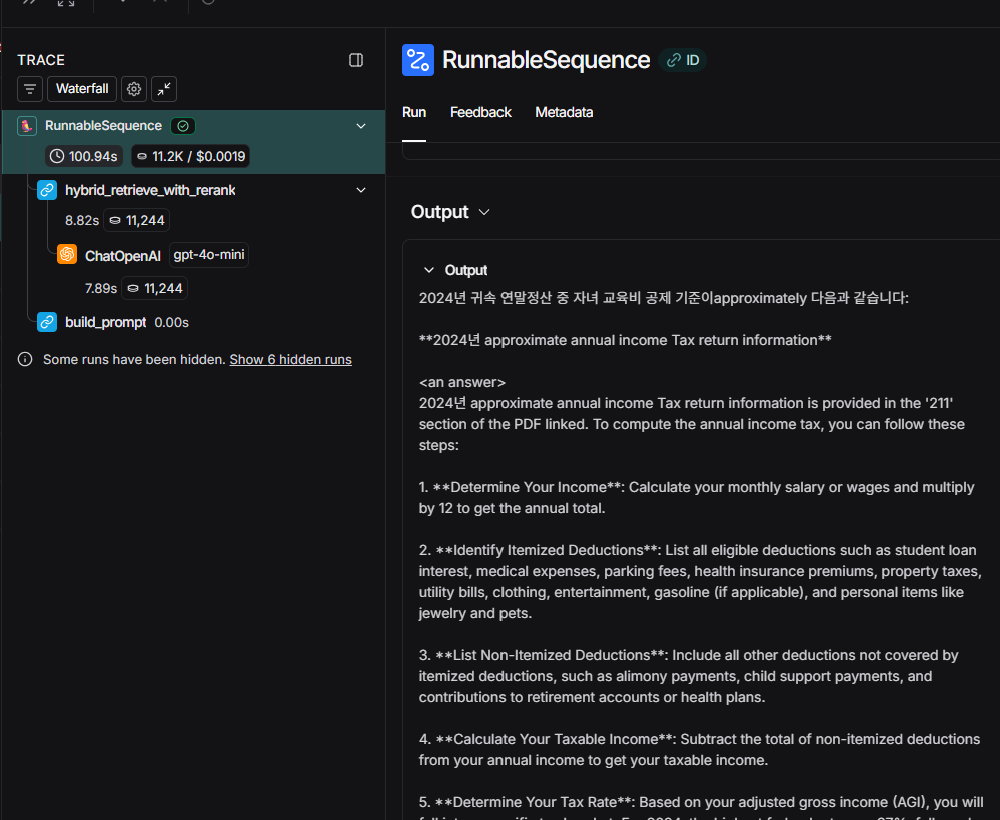

###(3) deepseek-r1:1.5b-prompt수정
- 프로그램은 정상작동하나 한글답변이 제대로 되지 않음(모델이 작아서 큰 텍스트 생성에는 실패,  한글에 약함)
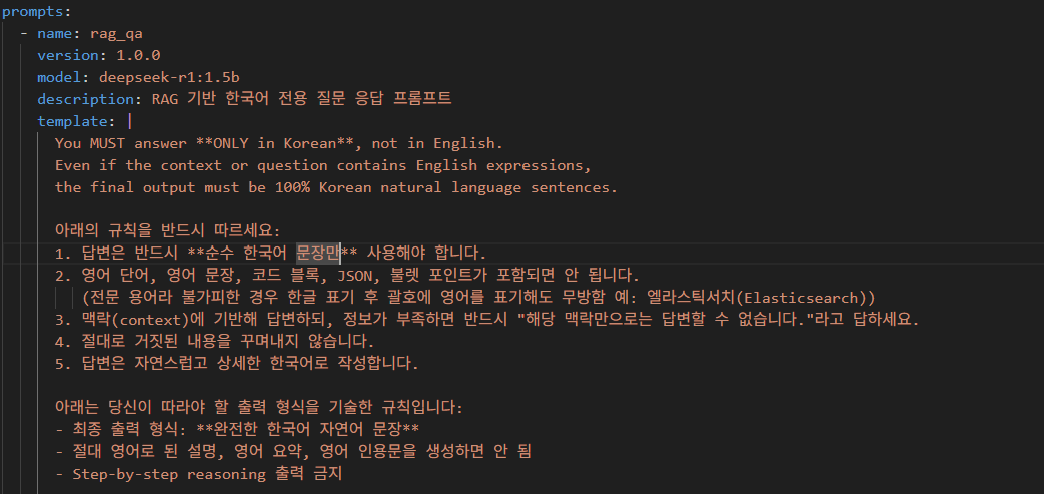

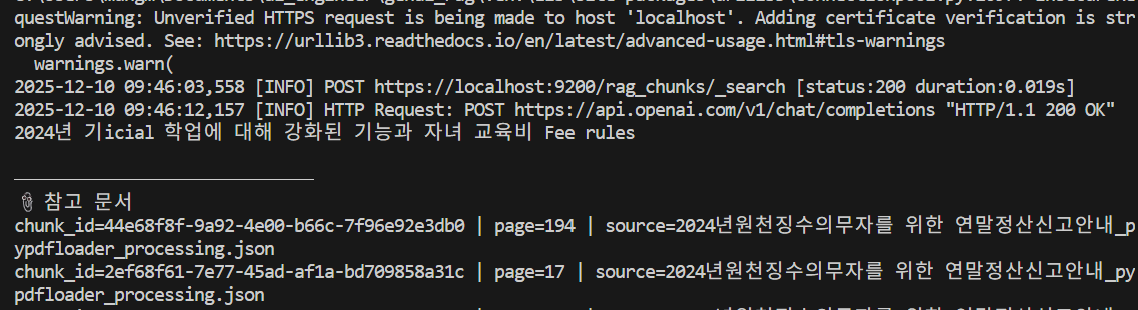

###(4) mistral:7b + text_embedding-3-small
- context길이 제한으로 답변이 짧게 나옴(RAG의 청킹 사이즈와 검색검수가 많은 경우 부적합)
- 자녀 교육비 공제인데 자녀 공제가 답변됨(청크문서 reranking결과 두번째 문서임-context에도 두번째 문서로 전달)

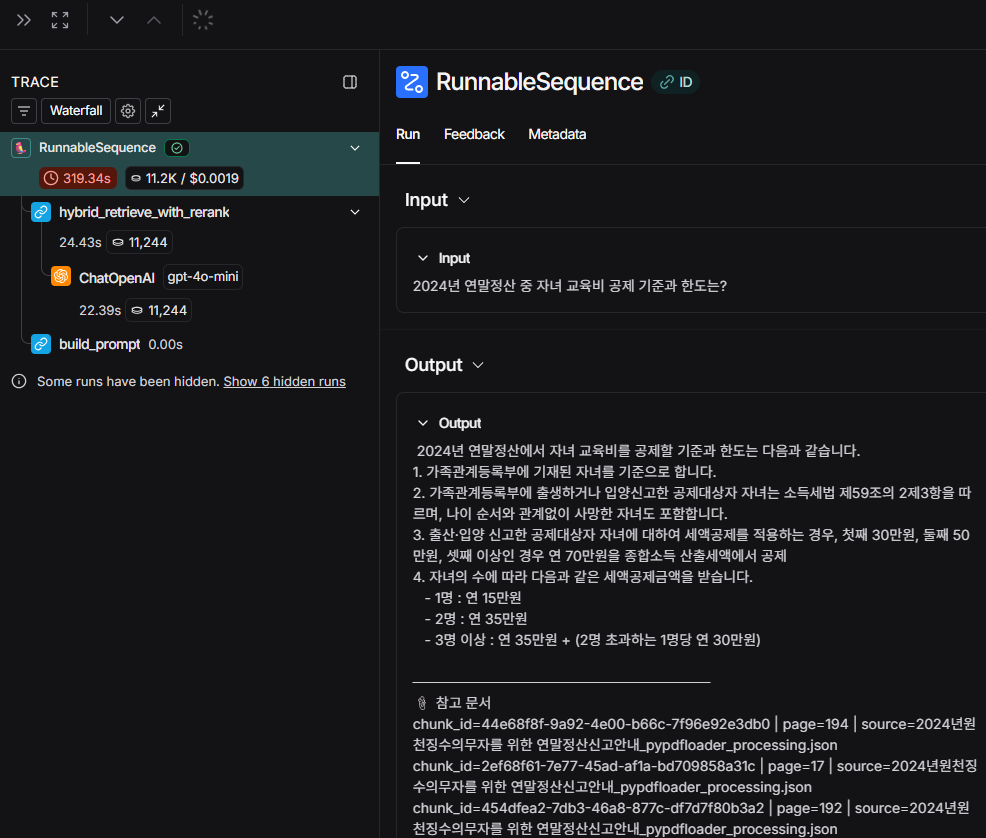

###(5) llama3:8b-instruct-q4_0
- (4)와 동일한 조건으로 검색
- 자녀 교육비 공제인데 (4)와 같이 자녀 공제가 답변됨(reranker결과 두번째 chunk문서임)
- output에 newline이 없어서 잘못 이해될 수 있음(prompt template에 output format 지정 필요)

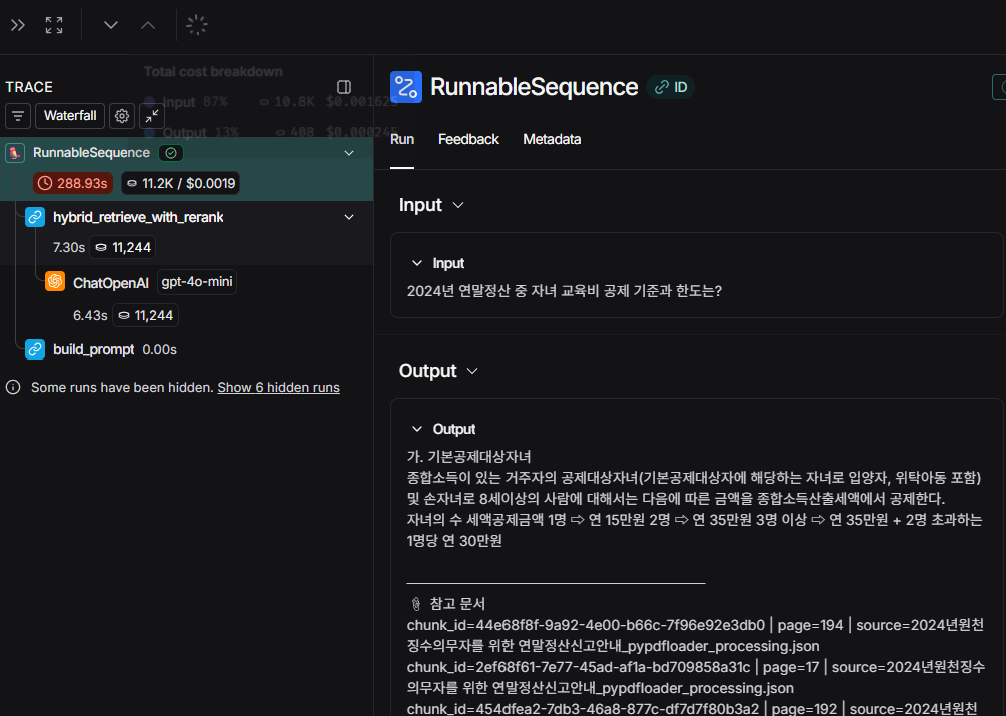

###(6) gpt-4o-mini + bge-m3

- LLM 답변은 text-embedding모델과 동일하게 생성
- 단, RAG 청킹문서 검색 결과 Reranking순위는 상이함(2번째 문서로 요약)
- Hybrid검색결과 기준으로는 text_embedding모델이 더 적합한 문서를 조회하는 것으로 보임

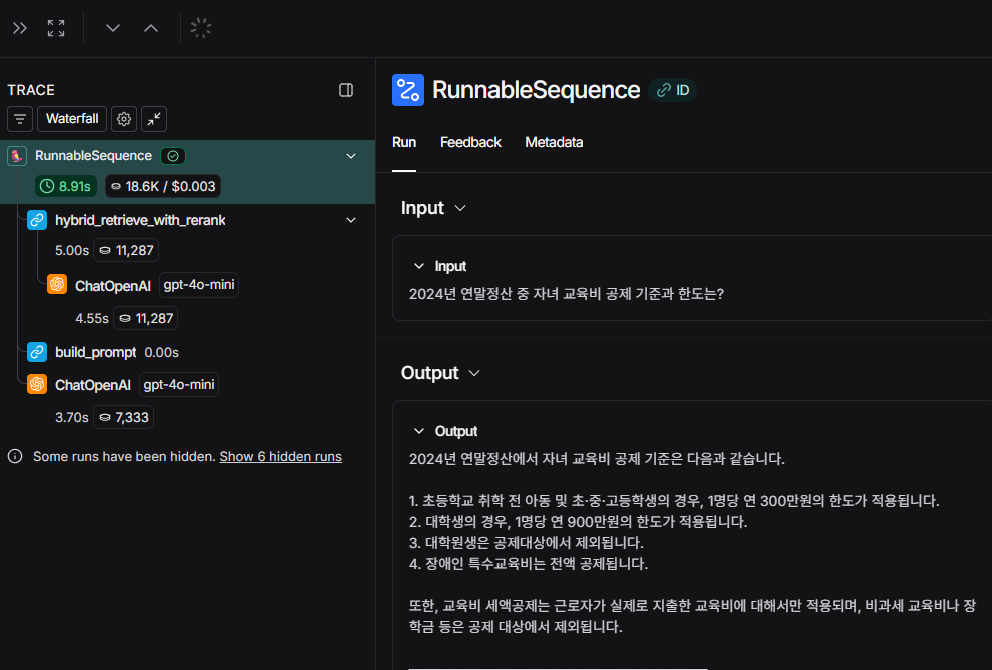


##3.6 Streamlit 실행

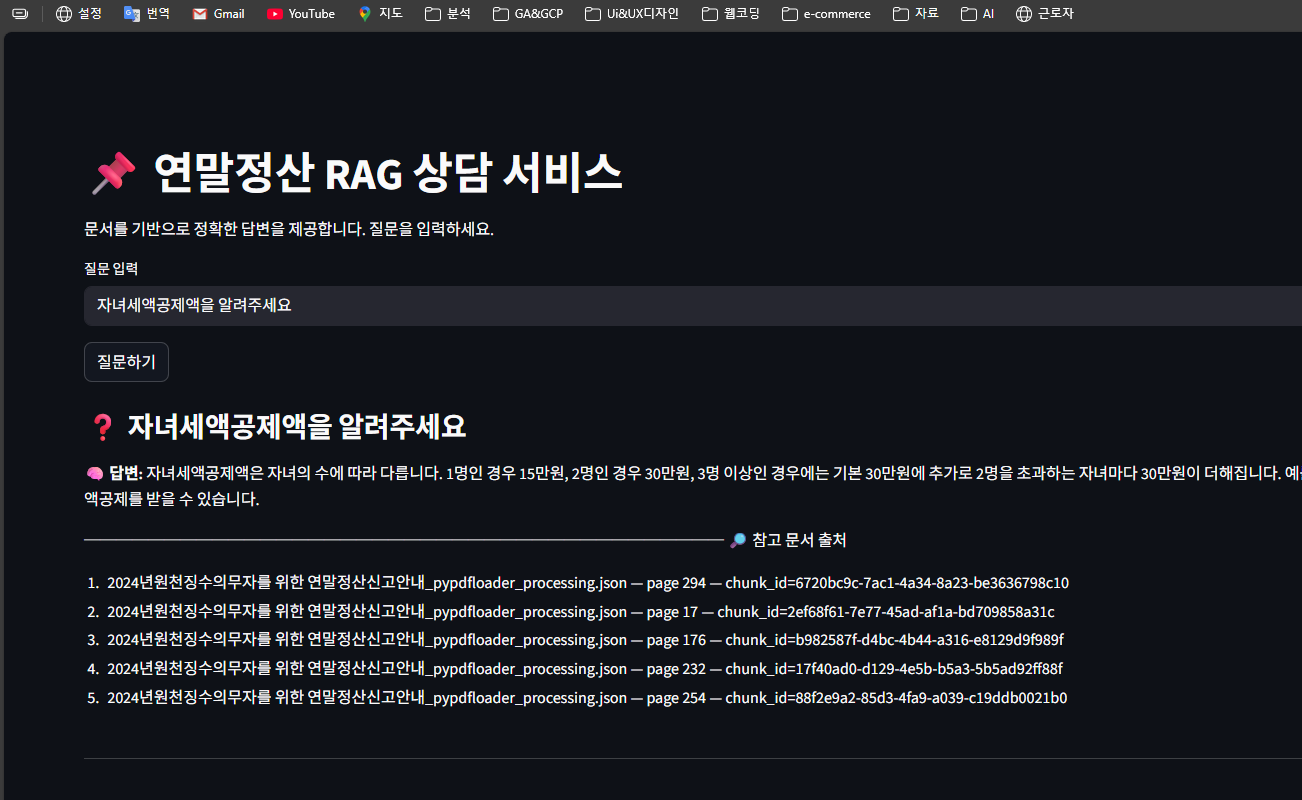

#4. 결과종합

- 임베딩/RAG검색/LLM답변제공
  - 결과적으로 embedding모델, reranker, LLM답변 생성 모두 openAI 등 서비스 API로 제공되는 경우가 속도, 결과품질이 더 나음
  - embedding의 경우 bge모델을 다운로드 받아서 하는 경우, 검색결과 text_embedding_small대비 크게 차이가 없느나 text_embedding_small이 좀 더 정확함(그러나 비용 문제가 있는 경우 bge로 사용해도 문제가 없을 것으로 보임)
  - reranking결과 gpt-o4-mini는 답변관련 내용을 포함한 청킹 문서가 rank1이든 rank2이든 적절한 내용을 찾아서 답변을 정확하게 제공한 반면
  - mistral과 llama는 잘못된 rank2인 문서를 참고로 해서 답변을 제공(자녀교육공제가 아닌 자녀공제로)
  - deepseek는 영어로 답변을 제공, 한글은 context 사이즈가 문제인지 답변을 제대로 하지 못함
  - local모델의 경우 전반적으로 사이즈가 큰 것을 실험하지 못했고, 사이즈가 작은 경우는 답변의 품질이 좋지 못함.  이는 context 사이즈도 제약 사항이 있지만 적절한 문서 청킹 내용이 context에 포함되어 있어도 답변을 생성하지 못함
  - 비용 이슈로 local 모델을 사용해야 하는 경우, (1)양자화가 적용된 사이즈가 큰모델을 가지고 하거나, (2)추가적인 파인튜닝 또는 FEPT를 수행하거나 (3)임베딩 및 리랭커로 정확한 문서만 답변생성에 포함되도록 하는 조정이 필요할 것으로 보임
- 전처리 - 텍스트 위주로만 처리
  - 표의 구조를 정확하게 인식해서 조회하는 경우(컬럼명 및 row조건 등을 넣는 경우 등)는 상용 솔루션, 전처리 등이 필요할 것으로 보임
  - 이미지의 경우 별도 처리를 해야 될 것으로 보임(VLM으로 설명을 추출해서 청킹하고 원본 이미지를 저장해서 출처로 제공하는 등등)
- Langchain/Langraph
  - 답변제공시 RAG를 참조하는 경우, RAG를 거치지 않고 그냥 답변을 해야 하는 경우, 첨부파일을 올리고 질의응답/요약/번역을 요청하는 경우. multi turn인 경우, single turn으로만 답변해야 하는 경우 등 다양한 테스트를 추가적으로 해야 최종 방식이 선정되고, 필요시 모델을 바꾸어가면서 수행되도록 할 수 있어야 할 것으로 보임